## Оглавление
1. [Обзор и предобработка данных](#pre_processing)
2. [Изучение и проверка данных](#analysis)
3. [Воронка событий](#funnel)
4. [Результаты эксперимента](#results)
5. [Общий вывод](#sumup)

**Поведение пользователей мобильного приложения**

Для стартапа, который продаёт продукты питания нужно разобраться, как ведут себя пользователи мобильного приложения. Нужно изучить воронку продаж и исследовать результаты эксперимента по замене шрифтов во всём приложении.

**Цель исследования** — изучить поведение пользователей мобильного приложения.

**Ход исследования**

Перед анализом данных понадобится обзор и предобработка данных. Необходимо проверить данные на ошибки и оценить их влияние на исследование.

Затем мы изучим воронку продаж, узнаем, как пользователи доходят до покупки, узнаем, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах?
После этого мы исследуем результаты A/A/B-эксперимента. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Таким образом, исследование пройдёт в четыре этапа:

- Обзор данных и предобработка данных.
- Изучение и проверка данных:
  - Сколько всего событий в логе?
  - Сколько всего пользователей в логе?
  - Сколько в среднем событий приходится на пользователя?
  - Данными за какой период мы располагаем? Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Много ли событий и пользователей мы потеряли, отбросив старые данные?
- Изучение воронки событий:
  - Какие события есть в логах, как часто они встречаются. 
  - Сколько пользователей совершали каждое из этих событий? Какова доля пользователей, которые хоть раз совершали событие.
  - В каком порядке происходят события? 
  - Какая доля пользователей проходит на следующий шаг воронки?
  - На каком шаге теряете больше всего пользователей?
  - Какая доля пользователей доходит от первого события до оплаты?
- Анализ результатов эксперимента:
  - Сколько пользователей в каждой экспериментальной группе?
  - Находят ли статистические критерии разницу между выборками?
  - Каково число и доля пользователей, совершивших это событие в каждой из  групп? Будет ли отличие между группами статистически достоверным. 
  - Какие выводы из эксперимента можно сделать?
  - Какой уровень значимости стоит применить? 
- Вывод.

## 1. Обзор и предобработка данных
<a name="pre_processing"></a>

In [91]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth

In [92]:
# изучим данные

try:
    data = pd.read_csv('logs_exp.csv', sep = '\t')
except:
    data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [93]:
data.info() # выведем сводную информацию о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [94]:
# переименум столбцы 
data = data.rename(
columns={
'EventName': 'event_name',
'DeviceIDHash': 'device_id_hash',
'EventTimestamp': 'event_timestamp',
'ExpId': 'exp_id',}
) 

In [95]:
# изменим тип данных в столбце с датой
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')

#добавим столбец с датой
data['date'] = pd.DatetimeIndex(data['event_timestamp']).date
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
 4   date             244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [96]:
#проверим столбец event_name на наличие неожиданных данных, не соответствующих типу события 
display(data['event_name'].describe())
data['event_name'].unique()

count               244126
unique                   5
top       MainScreenAppear
freq                119205
Name: event_name, dtype: object

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [97]:
#проверим столбец exp_id на наличие неожиданных данных, не соответствующих типу события 
display(data['exp_id'].unique())

array([246, 248, 247])

In [98]:
#проверим столбец date на наличие данных, отличных от даты
display(data['date'].describe(datetime_is_numeric=True))

count                           244126
mean     2019-08-03 21:33:08.209367296
min                2019-07-25 00:00:00
25%                2019-08-02 00:00:00
50%                2019-08-04 00:00:00
75%                2019-08-06 00:00:00
max                2019-08-07 00:00:00
Name: date, dtype: object

In [99]:
# проверим данные на дубликаты
data.duplicated().mean()

#процент дубликатов — 0,1, оставим их пока без изменений

0.0016917493425526163

## Вывод
В таблице 244126 строк и 4 столбца, присутствует 0,1% явных дубликатов, мы оставили их нетронутыми. Также мы заменили тип столбца с датой на datetime, добавили столбец с датой без времени и изменили названия строк в соответствии со змеиным регистром.

## 2. Изучение и проверка данных
<a name="analysis"></a>

### Задачи:
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
- Много ли событий и пользователей вы потеряли, отбросив старые данные?
- Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [100]:
# посчитаем, сколько всего событий в логе
events_total = len(data)
events_total

244126

In [101]:
# посчитаем, сколько всего пользователей в логе
users = data['device_id_hash'].nunique()
users

7551

In [102]:
# посчитаем среднее, медианное количество событий на пользователя, а также минимальное и максимальное количество событий
hey = data.groupby('device_id_hash', as_index=False).agg({'event_timestamp':'count'})
hey['event_timestamp'].describe()


count    7551.000000
mean       32.330287
std        65.312344
min         1.000000
25%         9.000000
50%        20.000000
75%        37.500000
max      2308.000000
Name: event_timestamp, dtype: float64

Среднее количество событий на пользователя — 32, медианное - 20. На разность показателей влияют аномальные данные: мы видим, что в данных есть пользователь(и), совершавшие 2308 событий. 

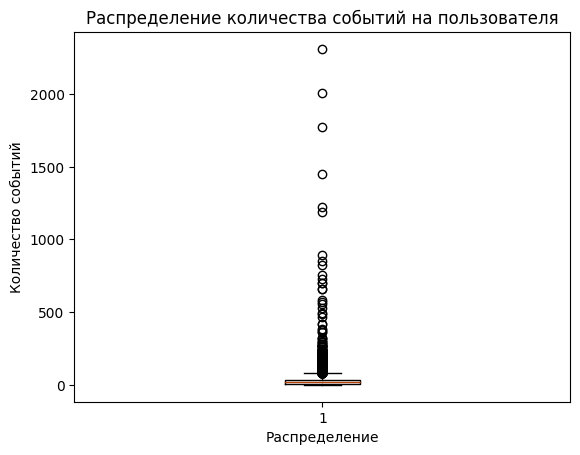

In [103]:
# посмотрим на распределение данных
plt.boxplot(hey['event_timestamp'])
plt.title("Распределение количества событий на пользователя")
plt.xlabel("Распределение")
plt.ylabel("Количество событий")
plt.show()

In [104]:
# посмотрим на выбросы
np.percentile(hey['event_timestamp'], [90, 95, 99])

array([ 64. ,  89. , 200.5])

Менее 5% пользователей совершает 89 событий, менее 1% пользователей совершает более 200 событий. Посчитаем, сколько покупателей уходит за 99 перцентиль.

In [105]:
# посчитаем, какое количество пользователей входит в 1% совершающих больше 200 событий (99 перцентиль) 
len(hey.query('event_timestamp > 200'))

76

In [106]:
# посмотрим, как эти пользователи распределены по группам
hey_group = data.groupby(['exp_id','device_id_hash'], as_index=False).agg({'event_timestamp':'count'})
hey_group = hey_group.query('event_timestamp > 200')
hey_group.groupby('exp_id').agg({'event_timestamp':'count'})

,event_timestamp
exp_id,
246,28
247,22
248,26


In [107]:
# найдем максимальную и минимальную дату
data['date'].describe(datetime_is_numeric=True)

count                           244126
mean     2019-08-03 21:33:08.209367296
min                2019-07-25 00:00:00
25%                2019-08-02 00:00:00
50%                2019-08-04 00:00:00
75%                2019-08-06 00:00:00
max                2019-08-07 00:00:00
Name: date, dtype: object

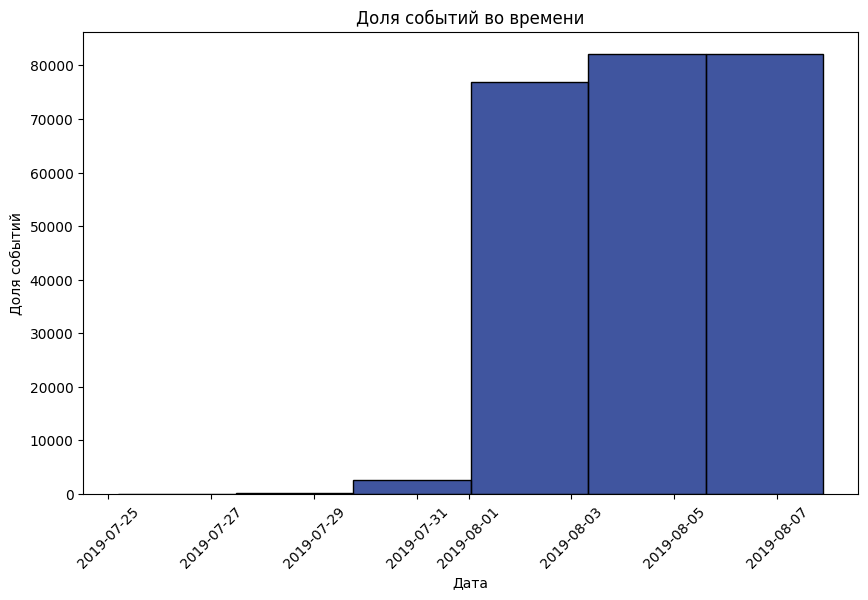

In [108]:
# построим график распределения объема событий во времени
plt.figure(
    figsize=(10, 6)
)
sns.set_palette('dark')
ax = sns.histplot(data=data['event_timestamp'], bins = 6)
plt.xticks(rotation=45)
ax.set_title('Доля событий во времени') 
ax.set_xlabel('Дата')
ax.set_ylabel('Доля событий') 
plt.show()

График показывает, что до первого августа событий было очень мало.

In [109]:
# проверим сколько событий мы потеряем, если отбросим данные, собранные до первого августа
len(data.query('date < "2019-08-01"'))

2828

In [110]:
# проверим сколько пользователей мы потеряем, если отбросим данные, собранные до первого августа
display(data.query('date < "2019-08-01"')['device_id_hash'].nunique())

# посчитаем процент пользователей, которых мы потеряем, если отбросим данные, собранные до первого августа
data.query('date < "2019-08-01"')['device_id_hash'].nunique() * 100 / data['device_id_hash'].nunique()



1451

19.215997881075353

In [111]:
# отбросим данные, собранные до первого августа
new_data = data.query('date >= "2019-08-01"')

In [112]:
# проверим, что у нас есть пользователи из всех групп
new_data.groupby('exp_id')['device_id_hash'].count()

exp_id
246    79425
247    77147
248    84726
Name: device_id_hash, dtype: int64

In [113]:
# проверим, есть ли пересечения по пользователям в разных группах
first = new_data.query('exp_id == 246').groupby('device_id_hash', as_index=False).agg('nunique')
first = first['device_id_hash']
second = new_data.query('exp_id == 247').groupby('device_id_hash', as_index=False).agg('nunique')
second = second['device_id_hash']
third = new_data.query('exp_id == 248').groupby('device_id_hash', as_index=False).agg('nunique')
third = third['device_id_hash']

display(first.isin(second).unique())
display(first.isin(third).unique())
display(second.isin(first).unique())
display(second.isin(third).unique())
display(third.isin(first).unique())
display(third.isin(second).unique())


array([False])

array([False])

array([False])

array([False])

array([False])

array([False])

## Вывод
В логе 244126 событий и 7551 уникальных пользователей за период с 25 июля по 7 августа 2019 года. Среднее количество событий на пользователя — 32, медианное - 20. На разность показателей влияют аномальные данные: мы видим, что в данных есть пользователь(и), совершавшие 2308 событий. Менее 5% пользователей совершает 89 событий, менее 1% пользователей совершает более 200 событий.  уходит за 99 перцентиль уходит 76 пользователей, которые следующим образом распределены по группам: 246 — 28, 247 — 22, 248 — 26.

Имеет смысл отбросить данные до 1 августа, т.к. событий до этой даты незначительное количество по сравнению с периодом с 1 по 7 августа. Таким образом мы исключим 2828 событий для 1451 уникального пользователя (19% от общего числа пользователей). 

В новых данных представлены пользователи из всех трех экспериментальных групп, каждый пользователь участвует только в одной группе теста.

## 3. Воронка событий
<a name="funnel"></a>

### Задачи:
- Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
- Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
- Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
- По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- На каком шаге теряете больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

In [114]:
# посчитаем, как часто встречаются события в логах 
events = new_data.groupby('event_name', as_index=False)['event_timestamp'].count().sort_values(by='event_timestamp', ascending=False)
events


,event_name,event_timestamp
1,MainScreenAppear,117431
2,OffersScreenAppear,46350
0,CartScreenAppear,42365
3,PaymentScreenSuccessful,34113
4,Tutorial,1039


In [115]:
# посчитаем, сколько пользователей совершали каждое из этих событий
total_users_new = new_data['device_id_hash'].nunique() # посчитаем общее количество уникальных пользователей в обновленной таблице
display(total_users_new)
users = new_data.groupby('event_name', as_index=False)['device_id_hash'].nunique().sort_values(by='device_id_hash', ascending=False)
users['ratio'] = users['device_id_hash']/total_users_new # добавим процент пользователей, совершивших событие, от общего их количества
users

7534

,event_name,device_id_hash,ratio
1,MainScreenAppear,7419,0.984736
2,OffersScreenAppear,4593,0.609636
0,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


In [116]:
# почти 2% покупателей пропустили первый шаг. Найдем их
first_step = list(new_data.query('event_name == "MainScreenAppear"')['device_id_hash'].unique())
no_first_step = new_data.query('device_id_hash not in @first_step')
display(no_first_step['device_id_hash'].nunique())

115

In [117]:
# посчитаем, какая доля пользователей проходит на следующий шаг воронки
users['share'] = users['device_id_hash'] / users['device_id_hash'].shift(1)
users

,event_name,device_id_hash,ratio,share
1,MainScreenAppear,7419,0.984736,NaN
2,OffersScreenAppear,4593,0.609636,0.619086
0,CartScreenAppear,3734,0.495620,0.812976
3,PaymentScreenSuccessful,3539,0.469737,0.947777
4,Tutorial,840,0.111495,0.237355


## Выводы
- В данных 4 вида событий: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial, первое из которых встречается чаще всего, и далее по убыванию.
- Количество пользователей, совершивших каждое из событий, распределено в таком же порядке. Процент пользователей, совершивших каждое событие, от общего их количества выглядит следующим образом: MainScreenAppear — 98%, OffersScreenAppear — 61%, CartScreenAppear - 49%, PaymentScreenSuccessful - 47%, Tutorial — 11%.
- Логичным выглядит, что события выстраиваются таким образом:  MainScreenAppear (открытие главной страницы), Tutorial (просмотр инструкции, OffersScreenAppear (просмотр страницы со специальным предложением), CartScreenAppear (добавление товара в корзину), PaymentScreenSuccessful (успешная оплата). При этом Tutorial смотрит очень малое количество покупателей, этот пункт выбивается из общего списка, т.к. по всей видимости не является обязательным для покупки.
- На следующий шаг воронки переходят следующие доли пользователей в расчете от предыдущего шага: страницу с предложением просматривают 62% их тех, кто зашел на главную, из них 81% добавляет товар в корзину, из которых 95% оплачивают заказ.
- Больше всего пользователей теряется на шаге просмотра специального предложения (если не брать во внимание просмотр обучающего видео, который не является обязательным шагом для покупки).
- От первого события до оплаты доходит 47% пользователей.

## 4. Результаты эксперимента
<a name="results"></a>

### Задачи:
- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. 
- Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

In [118]:
# посчитаем число пользователей в каждой группе
group_users = new_data.groupby('exp_id', as_index=False)['device_id_hash'].nunique()
display(group_users)

# посчитаем относительную разницу между количеством пользователей в контрольных группах
100 - group_users['device_id_hash'][0]/group_users['device_id_hash'][1] * 100

,exp_id,device_id_hash
0,246,2484
1,247,2513
2,248,2537


1.1539992041384721

Разница между количеством пользователей в контрольных группах составляет 1,15%, то есть пользователи по выборкам распределены корректно, и А/А тест можно проводить.

Проверим гипотезу о наличии статистически значимых различий в конверсиях между двумя группами с помощью z-теста.
- Нулевая гипотеза: пропорции равны.
- Альтернативная гипотеза: пропорции не равны.

Для критического уровня статистической значимости мы применяем поправку Бонферрони, т.к. будем сравнивать группы по множеству показателей и проводить несколько тестов с одними и теми же данными. 


In [119]:
# добавим фуекцию для расчета разницы пропорций двух выборок
def z_test(successes_sample_one, successes_sample_two, trials_sample_one, trials_sample_two):
    alpha = 0.1/12 # критический уровень статистической значимости
  
    successes = np.array([successes_sample_one, successes_sample_two])
    trials = np.array([trials_sample_one, trials_sample_two])
  
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
  
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
  
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
  
    # разница пропорций в датасетах
    difference = p1 - p2
  
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
      p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)  
  
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
  
    print('p-значение: ', p_value)
  
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между пропорциями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными'
    )

In [120]:
# создадим таблицу с количеством клиентов, совершивших каждое событие в каждой группе
group_events = (
    new_data.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc = 'nunique')
    .sort_values(246, ascending=False).reset_index()
)
display(group_events)


# все пользователи
all_users = new_data.groupby('exp_id')['device_id_hash'].nunique()

#создадим функцию для проверки данных воронки



exp_id,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [121]:
def foo(group_a, group_b, funnel_data, all_users_data):
    for index, row in funnel_data.iterrows():
        event = row['event_name']
        group_a_data = row[group_a]
        group_b_data = row[group_b]
        conversion_a = round(row[group_a] / all_users[group_a], 2)
        conversion_b = round(row[group_b] / all_users[group_b], 2)
        display('Результат этапа {} для групп {} (кол-во пользователей: {}, конверсия: {}) и {} (кол-во пользователей: {}, конверсия: {}):'.format(event, group_a, group_a_data, conversion_a, group_b, group_b_data, conversion_b))
        z_test(row[group_a], row[group_b], all_users_data[group_a], all_users_data[group_b])

Проверим гипотезу о наличии статистически значимых различий в конверсиях между контрольными группами 246 и 247 с помощью z-теста.

- Нулевая гипотеза: пропорции равны.
- Альтернативная гипотеза: пропорции не равны.

In [122]:
# сделаем проверку для групп 246 и 247
foo(246, 247, group_events, all_users)

'Результат этапа MainScreenAppear для групп 246 (кол-во пользователей: 2450, конверсия: 0.99) и 247 (кол-во пользователей: 2476, конверсия: 0.99):'

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа OffersScreenAppear для групп 246 (кол-во пользователей: 1542, конверсия: 0.62) и 247 (кол-во пользователей: 1520, конверсия: 0.6):'

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа CartScreenAppear для групп 246 (кол-во пользователей: 1266, конверсия: 0.51) и 247 (кол-во пользователей: 1238, конверсия: 0.49):'

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа PaymentScreenSuccessful для групп 246 (кол-во пользователей: 1200, конверсия: 0.48) и 247 (кол-во пользователей: 1158, конверсия: 0.46):'

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа Tutorial для групп 246 (кол-во пользователей: 278, конверсия: 0.11) и 247 (кол-во пользователей: 283, конверсия: 0.11):'

p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


Выберем самое популярное событие. Посчитаем число и долю пользователей, совершивших это событие в каждой из контрольных групп. Проверим, будет ли отличие между группами статистически достоверным.

In [123]:
# выберем самое популярное событие
popular_event = (
    new_data.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
    .reset_index().sort_values(by=246, ascending=False)
)
display(popular_event)
# это MainScreenAppear


exp_id,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [124]:
# посчитаем количество и процент пользователей, совершивших определенное событие, в каждой контрольной группе
def func(event_name, group_number):
    display('Численность группы {}, совершивших событие {}, составляет {} человек'.format(group_number, event_name, new_data.query('event_name == @event_name and exp_id == @group_number')['device_id_hash'].nunique()))
    display('Процент группы {}, совершивших событие {}, составляет {}'.format(group_number, event_name, round(100*new_data.query('event_name == @event_name and exp_id == @group_number')['device_id_hash'].nunique() / new_data['device_id_hash'].nunique(), 2)))

display(func('MainScreenAppear', 246))
display(func('OffersScreenAppear', 246))
display(func('CartScreenAppear', 246))
display(func('PaymentScreenSuccessful', 246))

display(func('MainScreenAppear', 247))
display(func('OffersScreenAppear', 247))
display(func('CartScreenAppear', 247))
display(func('PaymentScreenSuccessful', 247))

display(func('MainScreenAppear', 247))
display(func('OffersScreenAppear', 247))
display(func('CartScreenAppear', 247))
display(func('PaymentScreenSuccessful', 247))


'Численность группы 246, совершивших событие MainScreenAppear, составляет 2450 человек'

'Процент группы 246, совершивших событие MainScreenAppear, составляет 32.52'

None

'Численность группы 246, совершивших событие OffersScreenAppear, составляет 1542 человек'

'Процент группы 246, совершивших событие OffersScreenAppear, составляет 20.47'

None

'Численность группы 246, совершивших событие CartScreenAppear, составляет 1266 человек'

'Процент группы 246, совершивших событие CartScreenAppear, составляет 16.8'

None

'Численность группы 246, совершивших событие PaymentScreenSuccessful, составляет 1200 человек'

'Процент группы 246, совершивших событие PaymentScreenSuccessful, составляет 15.93'

None

'Численность группы 247, совершивших событие MainScreenAppear, составляет 2476 человек'

'Процент группы 247, совершивших событие MainScreenAppear, составляет 32.86'

None

'Численность группы 247, совершивших событие OffersScreenAppear, составляет 1520 человек'

'Процент группы 247, совершивших событие OffersScreenAppear, составляет 20.18'

None

'Численность группы 247, совершивших событие CartScreenAppear, составляет 1238 человек'

'Процент группы 247, совершивших событие CartScreenAppear, составляет 16.43'

None

'Численность группы 247, совершивших событие PaymentScreenSuccessful, составляет 1158 человек'

'Процент группы 247, совершивших событие PaymentScreenSuccessful, составляет 15.37'

None

'Численность группы 247, совершивших событие MainScreenAppear, составляет 2476 человек'

'Процент группы 247, совершивших событие MainScreenAppear, составляет 32.86'

None

'Численность группы 247, совершивших событие OffersScreenAppear, составляет 1520 человек'

'Процент группы 247, совершивших событие OffersScreenAppear, составляет 20.18'

None

'Численность группы 247, совершивших событие CartScreenAppear, составляет 1238 человек'

'Процент группы 247, совершивших событие CartScreenAppear, составляет 16.43'

None

'Численность группы 247, совершивших событие PaymentScreenSuccessful, составляет 1158 человек'

'Процент группы 247, совершивших событие PaymentScreenSuccessful, составляет 15.37'

None

Проверим гипотезу о наличии статистически значимых различий в конверсиях между контрольными и экспериментальной группами с помощью z-теста.

- Нулевая гипотеза: пропорции равны.
- Альтернативная гипотеза: пропорции не равны.

In [125]:
# сделаем проверку для групп 246 и 248
foo(246, 248, group_events, all_users)

'Результат этапа MainScreenAppear для групп 246 (кол-во пользователей: 2450, конверсия: 0.99) и 248 (кол-во пользователей: 2493, конверсия: 0.98):'

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа OffersScreenAppear для групп 246 (кол-во пользователей: 1542, конверсия: 0.62) и 248 (кол-во пользователей: 1531, конверсия: 0.6):'

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа CartScreenAppear для групп 246 (кол-во пользователей: 1266, конверсия: 0.51) и 248 (кол-во пользователей: 1230, конверсия: 0.48):'

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа PaymentScreenSuccessful для групп 246 (кол-во пользователей: 1200, конверсия: 0.48) и 248 (кол-во пользователей: 1181, конверсия: 0.47):'

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа Tutorial для групп 246 (кол-во пользователей: 278, конверсия: 0.11) и 248 (кол-во пользователей: 279, конверсия: 0.11):'

p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


In [126]:
# сделаем проверку для групп 247 и 248
foo(247, 248, group_events, all_users)

'Результат этапа MainScreenAppear для групп 247 (кол-во пользователей: 2476, конверсия: 0.99) и 248 (кол-во пользователей: 2493, конверсия: 0.98):'

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа OffersScreenAppear для групп 247 (кол-во пользователей: 1520, конверсия: 0.6) и 248 (кол-во пользователей: 1531, конверсия: 0.6):'

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа CartScreenAppear для групп 247 (кол-во пользователей: 1238, конверсия: 0.49) и 248 (кол-во пользователей: 1230, конверсия: 0.48):'

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа PaymentScreenSuccessful для групп 247 (кол-во пользователей: 1158, конверсия: 0.46) и 248 (кол-во пользователей: 1181, конверсия: 0.47):'

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа Tutorial для групп 247 (кол-во пользователей: 283, конверсия: 0.11) и 248 (кол-во пользователей: 279, конверсия: 0.11):'

p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


Проверим гипотезу о наличии статистически значимых различий в конверсиях между объединенными контрольными и экспериментальной группами с помощью z-теста.

- Нулевая гипотеза: пропорции равны.
- Альтернативная гипотеза: пропорции не равны.

In [127]:
# объединим контрольные группы
group_events['joint'] = group_events[246] + group_events[247]
display(group_events)

#добавим столбец с объединенным количеством пользователей в таблицу
all_users['joint'] = all_users[246] + all_users[247]
all_users

exp_id,event_name,246,247,248,joint
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358
4,Tutorial,278,283,279,561


exp_id
246      2484
247      2513
248      2537
joint    4997
Name: device_id_hash, dtype: int64

In [128]:
# сделаем проверку для объединенных контрольных групп и группы 248
foo('joint', 248, group_events, all_users)

'Результат этапа MainScreenAppear для групп joint (кол-во пользователей: 4926, конверсия: 0.99) и 248 (кол-во пользователей: 2493, конверсия: 0.98):'

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа OffersScreenAppear для групп joint (кол-во пользователей: 3062, конверсия: 0.61) и 248 (кол-во пользователей: 1531, конверсия: 0.6):'

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа CartScreenAppear для групп joint (кол-во пользователей: 2504, конверсия: 0.5) и 248 (кол-во пользователей: 1230, конверсия: 0.48):'

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа PaymentScreenSuccessful для групп joint (кол-во пользователей: 2358, конверсия: 0.47) и 248 (кол-во пользователей: 1181, конверсия: 0.47):'

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


'Результат этапа Tutorial для групп joint (кол-во пользователей: 561, конверсия: 0.11) и 248 (кол-во пользователей: 279, конверсия: 0.11):'

p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными


## Выводы
- 246 и 247 — контрольные группы, а 248 — экспериментальная. В контрольных группах 2450 и 2476 пользователей соответственно, в экспериментальной — 2493.
- Проверки разницы пропорций между зашедшими на главную и просмотревшими страницы со специальным предложеним / положившими товар в корзину / оплатившими заказ показали, что статистической разницы между контрольными группами, между каждой из контрольных групп и экспериментальной, а также между объединенными контрольными и экспериментальной нет.
- Было проведено 12 статистических тестов при уровне значимости 0.1/12 при поправке Бонферрони. Все тесты показали, что статистической значимости между группами нет: как контрольными, так и экспериментальной.
- Проверка гипотезы о равенстве средних контрольных групп между собой и каждой из конрольных групп с экспериментальной показала, что они равны.

# Общий вывод
<a name="sumup"></a>

Для стартапа, который продаёт продукты питания нам нужно было разобраться, как ведут себя пользователи мобильного приложения. Нужно было изучить воронку продаж и исследовать результаты эксперимента по замене шрифтов во всём приложении.

В ходе исследования мы проверили данные на пропуски, аномалии и дубликаты. 

Затем мы изучили воронку продаж: узнали какие события есть в логах, как часто они встречаются; сколько пользователей совершали каждое из этих событий; какова доля пользователей, которые хоть раз совершали событие; в каком порядке происходят события; какая доля пользователей проходит на следующий шаг воронки; на каком шаге теряете больше всего пользователей и какая доля пользователей доходит от первого события до оплаты.

После этого мы исследовали результаты A/A/B-эксперимента: узнали, сколько пользователей в каждой экспериментальной группе, находят ли статистические критерии разницу между выборками, выяснили число и долю пользователей, совершивших это событие в каждой из групп, а также будет ли отличие между группами статистически достоверным.

После обработки и проверки данных мы провели их анализ и сделали следующие выводы:
- В логе 244126 событий и 7551 уникальных пользователей за период с 25 июля по 7 августа 2019 года. Среднее количество событий на пользователя — 32, медианное - 20. 
- Мы отбросили данные до 1 августа, т.к. событий до этой даты незначительное количество по сравнению с периодом с 1 по 7 августа. Таким образом мы исключили 2828 событий для 1451 уникального пользователя (19% от общего числа пользователей). В новых данных представлены пользователи из всех трех экспериментальных групп, каждый пользователь участвует только в одной группе.
- В данных 4 вида событий: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial, первое из которых встречается чаще всего, и далее по убыванию.
- Количество пользователей, совершивших каждое из событий, распределено в таком же порядке. Процент пользователей, совершивших каждое событие, от общего их количества выглядит следующим образом: MainScreenAppear — 98%, OffersScreenAppear — 61%, CartScreenAppear - 49%, PaymentScreenSuccessful - 47%, Tutorial — 11%.
- Логичным выглядит, что события выстраиваются таким образом: MainScreenAppear (открытие главной страницы), Tutorial (просмотр инструкции, OffersScreenAppear (просмотр страницы со специальным предложением), CartScreenAppear (добавление товара в корзину), PaymentScreenSuccessful (успешная оплата). При этом Tutorial смотрит очень малое количество покупателей, этот пункт выбивается из общего списка, т.к. по всей видимости не является обязательным для покупки.
- На следующий шаг воронки переходят следующие доли пользователей в расчете от предыдущего шага: страницу с предложением просматривают 62% их тех, кто зашел на главную, из них 81% добавляет товар в корзину, из которых 95% оплачивают заказ.
- Больше всего пользователей теряется на шаге просмотра специального предложения (если не брать во внимание просмотр обучающего видео, который не является обязательным шагом для покупки).
- От первого события до оплаты доходит 47% пользователей.
- В контрольных группах 2450 и 2476 пользователей соответственно, в экспериментальной — 2493.
- Проверки разницы пропорций между зашедшими на главную и просмотревшими страницы со специальным предложеним / положившими товар в корзину / оплатившими заказ показали, что статистической разницы между контрольными группами, между каждой из контрольных групп и экспериментальной, а также между объединенными контрольными и экспериментальной нет.
- Было проведено 12 статистических тестов при уровне значимости 0.01/12 при поправке Бонферрони. Все тесты показали, что статистической значимости между группами нет: как контрольными, так и экспериментальной.
- Проверка гипотезы о равенстве средних контрольных групп между собой и каждой из конрольных групп с экспериментальной показала, что они равны.

Таким образом, можно сделать вывод, что статистической разницы между результатами групп в эксперименте по замене шрифта нет.